# Galaxy Cluster Redshift Classification Using Machine Learning

Spring 2024 - PHYS 2550 - Final Project

*Jade Ducharme, Zacharias Escalante, Fei Fan, Soren Helhoski, Shi Yan*

This project aims to develop a machine learning model for classifying the redshifts of background
galaxies behind galaxy clusters using observational cosmology. By leveraging photometric proper-
ties of stars and galaxies, the project seeks to calculate new redshift values for each galaxy and
compare these with known spectroscopic redshift values to evaluate the model’s accuracy.

In [1]:
# import necessary packages
import numpy as np
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# for aesthetics/plotting
sns.set_theme()
plt.style.use("seaborn-v0_8")

## Preprocessing

In [34]:
# Load data
from preprocess import load

data, labels, features = load("./data/clean_specz_fluxes.csv", mode="mag")

print("Data shape [input_size, num_features]:\t", data.shape)
print("Label size [input_size,]:\t\t", labels.shape,"\n")
print("Feature names:", features)

Data shape [input_size, num_features]:	 (51295, 7)
Label size [input_size,]:		 (51295,) 

Feature names: ['res' 'u_cmodel_mag' 'g_cmodel_mag' 'r_cmodel_mag' 'i_cmodel_mag'
 'z_cmodel_mag' 'Y_cmodel_mag']


Let's visualize our inputs. First, we can plot the 1D histogram for any of our input features:

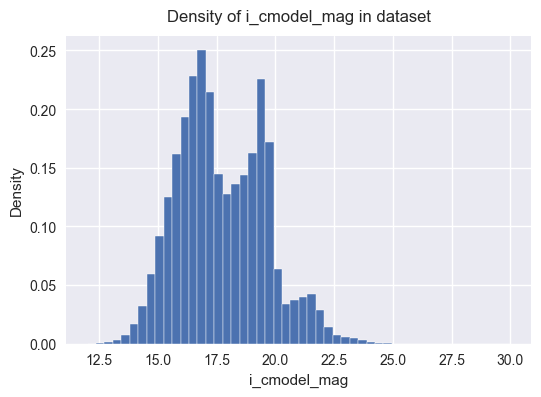

In [6]:
# Input visualization
from visualize import histogram_input

histogram_input(data, features, plot_feature="i_cmodel_mag", nbins=50, xrange=(12,30))

Next, we can also view how our labels align with any of the features in a 2D plot:

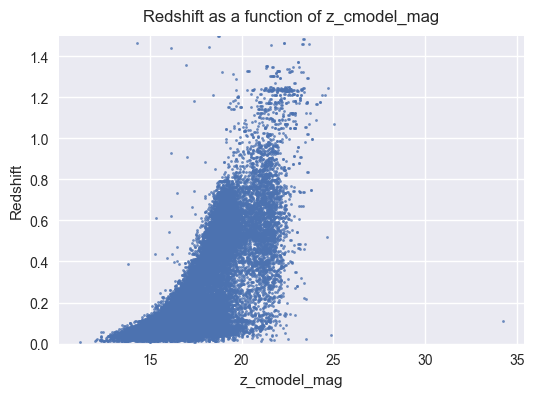

In [3]:
from visualize import plot_labels_features

plot_labels_features(data, labels, features, plot_feature="z_cmodel_mag", yrange=(0,1.5))

## Simple FCNN

As a first step, we would like to see how a simple FCNN performs.

In [35]:
from preprocess import preprocess_split
from model import SimpleFCNN, train_one_epoch, test
from sklearn.preprocessing import StandardScaler

# model initialization
simple_fcnn = SimpleFCNN(num_features=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(simple_fcnn.parameters(), lr=1e-4)
acc_metric = torchmetrics.R2Score()  # TODO: maybe find a better accuracy metric?

# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Device:",device,"\n")
simple_fcnn.to(device)

# Standardize your data
sc = StandardScaler()
data_scaled = sc.fit_transform(data.reshape(-1, data.shape[1]))

# Data preparation
train_set, val_set, test_set = preprocess_split(data_scaled, labels, train_split=0.7, val_split=0.15)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

num_epochs = 50
for e in range(1,num_epochs+1):

    # training
    loss, acc = train_one_epoch(simple_fcnn, device, train_loader, optimizer, criterion, acc_metric)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = test(simple_fcnn, device, val_loader, criterion, acc_metric)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if e%5 == 0:
      print(f"Epoch {e:02d}\t Train loss: {loss:.4f}\t Train acc: {acc:.4f}\t"\
            + f"Val loss: {val_loss:.4f}\t Val acc: {val_acc:.4f}"
      )

Device: cpu 

Epoch 05	 Train loss: 0.0339	 Train acc: -3.0756	Val loss: 0.0151	 Val acc: -3.1191
Epoch 10	 Train loss: 0.0316	 Train acc: -3.1339	Val loss: 0.0133	 Val acc: -3.1610
Epoch 15	 Train loss: 0.0309	 Train acc: -3.1801	Val loss: 0.0126	 Val acc: -3.1985
Epoch 20	 Train loss: 0.0300	 Train acc: -3.2222	Val loss: 0.0115	 Val acc: -3.2390
Epoch 25	 Train loss: 0.0297	 Train acc: -3.2471	Val loss: 0.0114	 Val acc: -3.2592
Epoch 30	 Train loss: 0.0294	 Train acc: -3.2644	Val loss: 0.0110	 Val acc: -3.2756
Epoch 35	 Train loss: 0.0291	 Train acc: -3.2809	Val loss: 0.0108	 Val acc: -3.2908
Epoch 40	 Train loss: 0.0289	 Train acc: -3.2914	Val loss: 0.0107	 Val acc: -3.2999
Epoch 45	 Train loss: 0.0284	 Train acc: -3.3025	Val loss: 0.0105	 Val acc: -3.3105
Epoch 50	 Train loss: 0.0283	 Train acc: -3.3135	Val loss: 0.0104	 Val acc: -3.3204


In [36]:
# How does the model perform on unseen data?

test_loss, test_acc = test(simple_fcnn, device, test_loader, criterion, acc_metric)

print(f"Final test loss: {test_loss:.4f}\t Final test acc: {test_acc:.4f}"
        )

Final test loss: 0.0218	 Final test acc: -3.3214


Next, we would like to visualize how our training went!

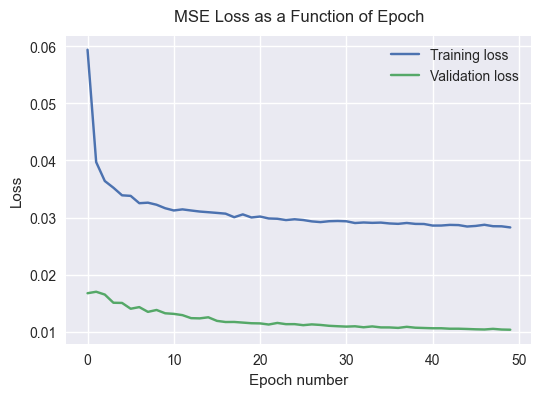

In [37]:
from visualize import plot_loss, plot_accuracy

plot_loss(loss_list, val_loss_list)

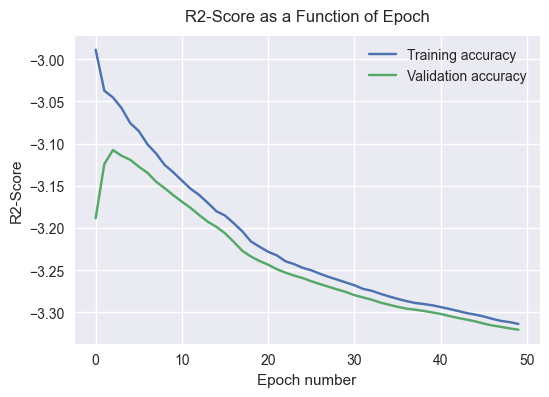

In [38]:
plot_accuracy(acc_list, val_acc_list)

Next, we would like to visualize the results of the model. In other words, given our set of test inputs, what kinds of outputs does our model predict?

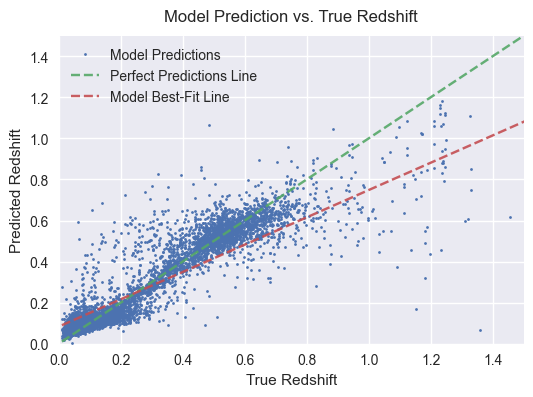

In [39]:
from visualize import visualize_predictions

visualize_predictions(test_set, simple_fcnn, device=device, xrange=(0,1.5), yrange=(0,1.5))

## 1D CNN

In [10]:
#TODO!